In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from tqdm import tqdm
import os
tqdm.pandas()

In [2]:
df = pd.read_csv("Dataset/training_data.csv", index_col=0)
df.time_hr = pd.to_timedelta(df.time_hr)

train = df.query("ds_type == 'train'")
test = df.query("ds_type != 'train'")

df[["dose_duration", "sex", "age", "age_category", 'subtype', 'height', 'weight', 'weight_kg', 'weight_estimated']].describe(include = "all")

,dose_duration,sex,age,age_category,subtype,height,weight,weight_kg,weight_estimated
count,0.0,120,120,120,120,0.0,120,1.200000e+02,120.0
unique,NaN,1,1,1,1,NaN,1,NaN,NaN
top,NaN,male,8-12 weeks,adolescent,Fisher,NaN,400 g,NaN,NaN
freq,NaN,120,120,120,120,NaN,120,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e-01,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.574390e-17,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e-01,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e-01,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e-01,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e-01,0.0


The dataset used for machine learning in the study about rifampicin was simulated from a population 
pharmacokinetic model. The data included simulated plasma concentrations of rifampicin and
covariates such as time post-dose, dose, treatment week, body mass index, age, sex, race, bod 
weight, height, HIV co-infection, and lean body mass without fat. The simulated rifampicn 
plasma concentrations and included covariates in the simulation were considered as the actal 
observed varation. 

In [3]:
df.weight_kg.value_counts()

weight_kg
0.4    120
Name: count, dtype: int64

Sadly there is no variance here, so it does not make sense to include as columns

In [4]:
train.columns

Index(['fk_series_id', 'time_original', 'conc_original', 'conc_sd_original',
       'conc_lower_bound_original', 'conc_upper_bound_original',
       'no_conc_val_type', 'time_hr', 'conc', 'conc_sd', 'conc_lower_bound',
       'conc_upper_bound', 'analyte_name_original', 'fk_analyzed_chemical_id',
       'author_comment', 'conc_units_normalized', 'analytical_method_detail',
       'n_subjects_in_series', 'fk_subject_id', 'conc_medium_normalized',
       'curator_comment', 'fk_study_id', 'radiolabeled', 'analyte_dtxsid',
       'analyte_casrn', 'test_substance_dtxsid', 'test_substance_casrn',
       'fk_test_chemical_id', 'fk_dosed_chemical_id', 'dose_level_normalized',
       'administration_route_normalized', 'dose_duration', 'parameter_name',
       'parameter_value', 'species', 'sex', 'age', 'age_category', 'notes',
       'subtype', 'height', 'weight', 'weight_kg', 'weight_estimated',
       'series_length', 'ds_type'],
      dtype='object')

We also can't think of any other usefull ones so we will just use initial dose

In [5]:

def extract_data(series):
    inital_dose = series.dose_level_normalized.iloc[0]
    series = series.sort_values("time_hr")
    
    
    return pd.Series([inital_dose] + series.conc.values.tolist(), index= ["initial_dose"] + series.time_hr.dt.days.values.tolist())
    
    
train = train.groupby("fk_series_id").apply(extract_data)
test = test.groupby("fk_series_id").apply(extract_data)

In [6]:
train.initial_dose.value_counts()

initial_dose
550.0    17
55.0     15
Name: count, dtype: int64

There is only two different initial doses

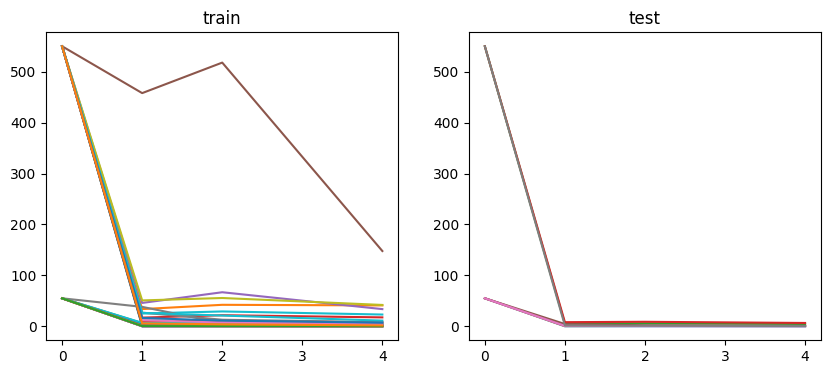

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2 , 1)
for row in train.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("train")


plt.subplot(1, 2, 2)
for row in test.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("test")
plt.show()

Drop outlier

In [8]:
outlier_row = train[2].idxmax()
train = train.drop(index=outlier_row)

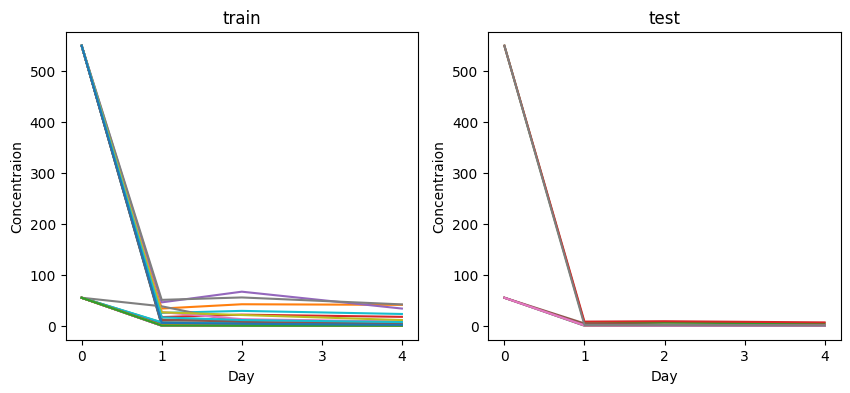

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2 , 1)
for row in train.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("train")
plt.xlabel("Day")
plt.ylabel("Concentraion")

plt.subplot(1, 2, 2)
for row in test.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("test")
plt.xlabel("Day")
plt.ylabel("Concentraion")
plt.show()

### Z normalize

In [10]:
train_mean, train_std = train.mean(), train.std()

train_norm = (train - train_mean) / train_std
test_norm = (test - train_mean) / train_std
test_norm.mean(), test_norm.std()

(initial_dose   -0.277813
 1              -0.582924
 2              -0.479505
 4              -0.457892
 dtype: float64,
 initial_dose    1.018797
 1               0.193204
 2               0.190489
 4               0.206569
 dtype: float64)

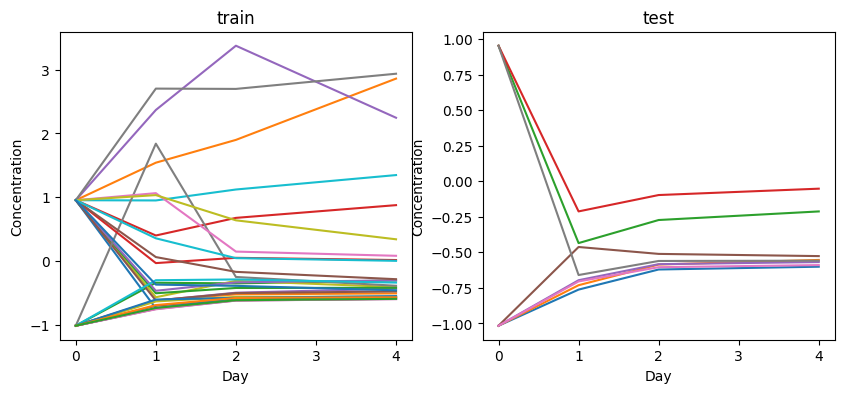

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2 , 1)
for row in train_norm.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("train")
plt.xlabel("Day")
plt.ylabel("Concentration")

plt.subplot(1, 2, 2)
for row in test_norm.values:
    plt.plot([0, 1, 2 ,4], row)
plt.title("test")
plt.xlabel("Day")
plt.ylabel("Concentration")
plt.show()

the train set really differs from the test set, we cant expect good generalization

In [12]:
def only_initial_dose(df):
    
    x = df.initial_dose.values[:, None]
    y = df.iloc[:,1:].values
    
    return x, y

def initial_dose_and_first_two(df):
    
    x = df.iloc[:, :-1].values
    y = df.iloc[:,-1].values
    
    return x, y


## Predict 3 time steps from initial dose

TThe studyabout rifampicin concentration  used several machine learning
algorithms, such as LASSO, Gradient Boosting Machines, XGBoost, and Random Forest, to 
predict rifampicin plasma concentration and area under the concentration-time curve (AU) 
after repe administration.   
n.  The results of the article about rifampicin showed that the XGBoost algorithm performed best in predicting the 
complete time series of rifampicin plasmacconcentration, with a coefficient of determination
(R²) of 0.84, a root mean square error (RMSE) of 6.9 mg/L, and a mean absolute error (MAE) 
of 4.0 mg/L. When predicting the 0-24h AUC, XGBoost also performed best. 


In [14]:
train_x, train_y = only_initial_dose(train_norm)
test_x, test_y = only_initial_dose(test_norm)

In [15]:
from sklearn.model_selection import GridSearchCV


def eval_model(model, parameters):
    
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='explained_variance', verbose=1, return_train_score=False, n_jobs=os.cpu_count() -1)
    grid_search.fit(train_x, train_y)
    return grid_search.best_score_
    

In [16]:
from sklearn.ensemble import RandomForestRegressor

parameters_rf = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],     
    'min_samples_split': [2, 10, 20]     
}

model = RandomForestRegressor(n_estimators=100)
eval_model(model, parameters_rf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


0.07160133550480728

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

linear_parameters = {
    'poly__degree': [1, 2, 3, 4, 5] 
}
eval_model(model, linear_parameters)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


0.024283192606450725

In [18]:
from sklearn.linear_model import MultiTaskLasso

parameters_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10] 
}
model = MultiTaskLasso()
eval_model(model, parameters_lasso)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


0.04458000171416191

Best model is RF

In [19]:
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(model, parameters_rf, cv=5, scoring='explained_variance', verbose=1, return_train_score=False, n_jobs=os.cpu_count() -1)
grid_search.fit(train_x, train_y)
model = grid_search.best_estimator_
model.fit(train_x, train_y)

test_preds = model.predict(test_x)
r2_score(test_y, test_preds)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


-7.607124545732706

The best model is the random forest, but the R² remains much too low.

## Predict only last time step

In [20]:
train_x, train_y = initial_dose_and_first_two(train_norm)
test_x, test_y = initial_dose_and_first_two(test_norm)

In [21]:
from sklearn.ensemble import RandomForestRegressor

parameters_rf = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30],     
    'min_samples_split': [2, 10, 20]     
}

model = RandomForestRegressor(n_estimators=100)
eval_model(model, parameters_rf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


0.9009724691369531

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

linear_parameters = {
    'poly__degree': [1, 2, 3, 4, 5] 
}
eval_model(model, linear_parameters)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


0.8003075087915119

In [23]:
from sklearn.linear_model import Lasso

parameters_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10] 
}
model = Lasso()
eval_model(model, parameters_lasso)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


0.872443277028756

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'min_samples_split': [2, 4, 6]  
}

model = GradientBoostingRegressor()
eval_model(model, param_grid)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


0.8996262714988376

Best model is Gradient Boosting -> eval

In [25]:
from sklearn.metrics import r2_score
param_grid = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'min_samples_split': [2, 4, 6]  
}

model = GradientBoostingRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='explained_variance', verbose=1, return_train_score=False, n_jobs=os.cpu_count() -1)
grid_search.fit(train_x, train_y)
model = grid_search.best_estimator_
model.fit(train_x, train_y)

test_preds = model.predict(test_x)
r2_score(test_y, test_preds)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


0.7410598921556635

## Visualize Predictions

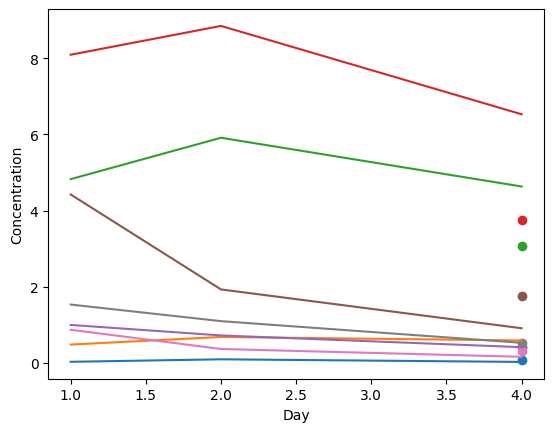

In [27]:
preds_rescaled = test_preds * train_std[4] + train_mean[4]

for i, (pred, row) in enumerate(zip(preds_rescaled,test.values)):
    
    
    plt.plot([1, 2, 4], row[1:], label=f'Series {i+1}')
    plt.scatter(4, pred, label=f'Series {i+1}')
plt.xlabel("Day")
plt.ylabel("Concentration")
plt.show()

We only obtained a decent result for the prediction of the first step. After that, the model's predictions diverge significantly. This is due to the fact that the only feature we have is the initial concentration. Additionally, there are only two different initial concentrations in our dataset. The model almost solely adds a random variation coefficient, which allows for a good correlation coefficient for the prediction of the first step. However, the actual value then deviates too much from the initial concentration, making it impossible to predict the random variable. In short, we are aware that our model does not work, but an initial concentration with only two values and no variance among the subjects does not allow for the training of a machine learning model.